In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
nickfratto_pacs_dataset_path = kagglehub.dataset_download('nickfratto/pacs-dataset')

print('Data source import complete.')


/home/hhabib/.pyenv/versions/AIML/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data source import complete.


In [2]:
import kagglehub
import torch
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, ConcatDataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import tqdm as tq
import timm
import numpy as np
from torch.utils.data import Subset
import kagglehub

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

In [4]:
pacs_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [5]:
PACS_base_path = kagglehub.dataset_download("nickfratto/pacs-dataset")

In [6]:
PACS_base_path = kagglehub.dataset_download("nickfratto/pacs-dataset")

pacs_sketch_dataset = datasets.ImageFolder(
    root=f"{PACS_base_path}/pacs_data/pacs_data/sketch",
    transform=pacs_transforms
)
pacs_cartoon_dataset = datasets.ImageFolder(
    root=f"{PACS_base_path}/pacs_data/pacs_data/cartoon",
    transform=pacs_transforms
)
pacs_art_dataset = datasets.ImageFolder(
    root=f"{PACS_base_path}/pacs_data/pacs_data/art_painting",
    transform=pacs_transforms
)
pacs_photo_dataset = datasets.ImageFolder(
    root=f"{PACS_base_path}/pacs_data/pacs_data/photo",
    transform=pacs_transforms
)

print(f"Dataset sizes:")
print(f"  Art: {len(pacs_art_dataset)}")
print(f"  Photo: {len(pacs_photo_dataset)}")
print(f"  Cartoon: {len(pacs_cartoon_dataset)}")
print(f"  Sketch (target): {len(pacs_sketch_dataset)}")

Dataset sizes:
  Art: 2048
  Photo: 1670
  Cartoon: 2344
  Sketch (target): 3929


In [7]:
def create_splits(dataset, test_ratio=0.2):
    """Create train/test split with proper ratio"""
    total_size = len(dataset)
    test_size = int(total_size * test_ratio)
    train_size = total_size - test_size

    # Shuffle indices
    indices = torch.randperm(total_size).tolist()

    train_indices = indices[:train_size]
    test_indices = indices[train_size:]

    train_subset = Subset(dataset, train_indices)
    test_subset = Subset(dataset, test_indices)

    return train_subset, test_subset

# Create splits for source domains
pacs_art_train, pacs_art_test = create_splits(pacs_art_dataset)
pacs_photo_train, pacs_photo_test = create_splits(pacs_photo_dataset)
pacs_cartoon_train, pacs_cartoon_test = create_splits(pacs_cartoon_dataset)

print(f"\nTrain/Test splits:")
print(f"  Art: {len(pacs_art_train)}/{len(pacs_art_test)}")
print(f"  Photo: {len(pacs_photo_train)}/{len(pacs_photo_test)}")
print(f"  Cartoon: {len(pacs_cartoon_train)}/{len(pacs_cartoon_test)}")


Train/Test splits:
  Art: 1639/409
  Photo: 1336/334
  Cartoon: 1876/468


In [8]:
train_dataset = ConcatDataset([pacs_art_train, pacs_photo_train, pacs_cartoon_train])
source_test_dataset = ConcatDataset([pacs_photo_test, pacs_art_test, pacs_cartoon_test])

# Loaders for combined datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
source_test_loader = DataLoader(source_test_dataset, batch_size=32, shuffle=False)
target_loader = DataLoader(pacs_sketch_dataset, batch_size=32, shuffle=False)

# Individual domain loaders for GroupDRO (FIXED - using training subsets)
art_loader = DataLoader(pacs_art_train, batch_size=32, shuffle=True)
photo_loader = DataLoader(pacs_photo_train, batch_size=32, shuffle=True)
cartoon_loader = DataLoader(pacs_cartoon_train, batch_size=32, shuffle=True)
train_loaders = [art_loader, photo_loader, cartoon_loader]

In [12]:
class Algorithm(torch.nn.Module):
    """
    A subclass of Algorithm implements a domain generalization algorithm.
    Subclasses should implement the following:
    - update()
    - predict()
    """
    def __init__(self, input_shape, num_classes, num_domains, hparams):
        super(Algorithm, self).__init__()
        self.hparams = hparams

    def update(self, minibatches, unlabeled=None):
        """
        Perform one update step, given a list of (x, y) tuples for all
        environments.

        Admits an optional list of unlabeled minibatches from the test domains,
        when task is domain_adaptation.
        """
        raise NotImplementedError

    def predict(self, x):
        raise NotImplementedError

In [13]:
class ERM(Algorithm):
    """
    Empirical Risk Minimization (ERM)
    """

    def __init__(self, input_shape, num_classes, num_domains, hparams):
        super(ERM, self).__init__(input_shape, num_classes, num_domains,
                                  hparams)
        self.featurizer = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.classifier = nn.Linear(
            self.featurizer.fc.in_features,
            num_classes)
        self.featurizer.fc = nn.Identity()


        self.network = nn.Sequential(self.featurizer, self.classifier)
        self.optimizer = torch.optim.Adam(
            self.network.parameters(),
            lr=self.hparams["lr"],
            weight_decay=self.hparams['weight_decay']
        )

        self.normalize = torch.nn.Sequential(
            # timm models expect 224x224 RGB normalized to ImageNet stats
            nn.Identity()
        )

    def update(self, minibatches, unlabeled=None):
        all_x = torch.cat([x for x, y in minibatches])
        all_y = torch.cat([y for x, y in minibatches])
        loss = F.cross_entropy(self.predict(all_x), all_y)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return {'loss': loss.item()}

    def predict(self, x):
        return self.network(x)

In [14]:
class GroupDRO(ERM):
    """
    Robust ERM minimizes the error at the worst minibatch
    Algorithm 1 from [https://arxiv.org/pdf/1911.08731.pdf]
    """
    def __init__(self, input_shape, num_classes, num_domains, hparams):
        super(GroupDRO, self).__init__(input_shape, num_classes, num_domains,
                                        hparams)
        self.register_buffer("q", torch.Tensor())

    def update(self, minibatches, unlabeled=None):
        device = "cuda" if minibatches[0][0].is_cuda else "cpu"

        if not len(self.q):
            self.q = torch.ones(len(minibatches)).to(device)

        losses = torch.zeros(len(minibatches)).to(device)
        total = 0
        correct = 0
        accuracy = 0
        for m in range(len(minibatches)):
            x, y = minibatches[m]
            logits = self.predict(x)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += len(y)
            losses[m] = F.cross_entropy(logits, y)
            self.q[m] *= (self.hparams["groupdro_eta"] * losses[m].data).exp()
        accuracy = correct / total
        self.q /= self.q.sum()

        loss = torch.dot(losses, self.q)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return {'loss': loss.item(), 'accu': accuracy}


In [12]:
def evaluate(model, data_loader, device, desc="Evaluating"):
    """Evaluate model on a dataset"""
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in tq.tqdm(data_loader, desc=desc):
            x, y = x.to(device), y.to(device)
            logits = model.network(x)
            _, predicted = torch.max(logits.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [16]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

def evaluate_per_domain(model, data_loaders, device, desc="Evaluating"):
    """Evaluate model on individual domains separately"""
    model.eval()
    accuracies = {}

    with torch.no_grad():
        for domain_name, loader in data_loaders.items():
            correct = 0
            total = 0
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                logits = model.network(x)
                _, predicted = torch.max(logits.data, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()

            accuracy = 100 * correct / total
            accuracies[domain_name] = accuracy

    return accuracies


# In your training loop, modify to track per-domain metrics:

h_params = {
    'lr': 5e-5,
    'weight_decay': 1e-4,
    'groupdro_eta': 0.01
}

g_dro_model = GroupDRO(3 * 224 * 224, 7, 3, hparams=h_params).to(device)
num_epochs = 5

# Create per-domain test loaders for tracking
test_loaders = {
    'Art': DataLoader(pacs_art_test, batch_size=32, shuffle=False),
    'Photo': DataLoader(pacs_photo_test, batch_size=32, shuffle=False),
    'Cartoon': DataLoader(pacs_cartoon_test, batch_size=32, shuffle=False),
}

print(f"\n{'='*60}")
print(f"Training GroupDRO for {num_epochs} epochs")
print(f"{'='*60}\n")

g_dro_model.train()

# Store metrics for analysis
training_history = {
    'epoch': [],
    'train_loss': [],
    'train_acc': [],
    'art_acc': [],
    'photo_acc': [],
    'cartoon_acc': [],
    'worst_group_acc': [],
    'source_avg_acc': [],
    'sketch_acc': []
}

for epoch in range(num_epochs):
    iters = [iter(loader) for loader in train_loaders]
    steps_per_epoch = max(len(loader) for loader in train_loaders)

    pbar = tqdm(range(steps_per_epoch), desc=f"Epoch {epoch + 1}/{num_epochs}")

    epoch_metrics = {"loss": [], "accu": []}

    for step in pbar:
        minibatches = []

        # Get batch from each domain
        for i, it in enumerate(iters):
            try:
                x, y = next(it)
            except StopIteration:
                iters[i] = iter(train_loaders[i])
                x, y = next(iters[i])

            x, y = x.to(device), y.to(device)
            minibatches.append((x, y))

        # Update model
        metrics = g_dro_model.update(minibatches)

        # Store metrics
        for key in epoch_metrics:
            epoch_metrics[key].append(metrics[key])

        # Calculate running averages
        window = min(50, len(epoch_metrics['accu']))
        avg_loss = sum(epoch_metrics['loss'][-window:]) / window
        avg_acc = sum(epoch_metrics['accu'][-window:]) / window

        pbar.set_postfix({
            'Loss': f"{avg_loss:.3f}",
            'Acc': f"{avg_acc:.3f}"
        })

    # Evaluate on individual domains after each epoch
    print(f"\nEpoch {epoch + 1} Results:")

    domain_accs = evaluate_per_domain(g_dro_model, test_loaders, device)
    source_avg_acc = sum(domain_accs.values()) / len(domain_accs)
    worst_group_acc = min(domain_accs.values())

    print(f"  Art Accuracy:     {domain_accs['Art']:.2f}%")
    print(f"  Photo Accuracy:   {domain_accs['Photo']:.2f}%")
    print(f"  Cartoon Accuracy: {domain_accs['Cartoon']:.2f}%")
    print(f"  Source Avg Acc:   {source_avg_acc:.2f}%")
    print(f"  Worst Group Acc:  {worst_group_acc:.2f}%")

    # Evaluate on target domain
    target_acc = evaluate(g_dro_model, target_loader, device, "Target Test")
    print(f"  Target (Sketch) Accuracy: {target_acc:.2f}%")
    print()

    # Store in history
    training_history['epoch'].append(epoch + 1)
    training_history['train_loss'].append(sum(epoch_metrics['loss']) / len(epoch_metrics['loss']))
    training_history['train_acc'].append(sum(epoch_metrics['accu']) / len(epoch_metrics['accu']))
    training_history['art_acc'].append(domain_accs['Art'])
    training_history['photo_acc'].append(domain_accs['Photo'])
    training_history['cartoon_acc'].append(domain_accs['Cartoon'])
    training_history['worst_group_acc'].append(worst_group_acc)
    training_history['source_avg_acc'].append(source_avg_acc)
    training_history['sketch_acc'].append(target_acc)


# Print summary table
print(f"\n{'='*100}")
print(f"TRAINING HISTORY SUMMARY")
print(f"{'='*100}")
print(f"{'Epoch':<8} {'Loss':<10} {'Art':<10} {'Photo':<10} {'Cartoon':<10} {'Worst':<10} {'Src Avg':<10} {'Sketch':<10}")
print(f"{'-'*100}")

for i in range(len(training_history['epoch'])):
    print(f"{training_history['epoch'][i]:<8} "
          f"{training_history['train_loss'][i]:<10.4f} "
          f"{training_history['art_acc'][i]:<10.2f} "
          f"{training_history['photo_acc'][i]:<10.2f} "
          f"{training_history['cartoon_acc'][i]:<10.2f} "
          f"{training_history['worst_group_acc'][i]:<10.2f} "
          f"{training_history['source_avg_acc'][i]:<10.2f} "
          f"{training_history['sketch_acc'][i]:<10.2f}")

print(f"{'='*100}\n")

# Find best epoch based on worst group accuracy and target accuracy
best_worst_epoch = max(range(len(training_history['epoch'])),
                        key=lambda i: training_history['worst_group_acc'][i])
best_target_epoch = max(range(len(training_history['epoch'])),
                        key=lambda i: training_history['sketch_acc'][i])

print(f"Best Worst Group Accuracy: {training_history['worst_group_acc'][best_worst_epoch]:.2f}% "
      f"(Epoch {training_history['epoch'][best_worst_epoch]})")
print(f"Best Target Accuracy: {training_history['sketch_acc'][best_target_epoch]:.2f}% "
      f"(Epoch {training_history['epoch'][best_target_epoch]})")
print(f"\nWorst Group Improvement: "
      f"{training_history['worst_group_acc'][-1] - training_history['worst_group_acc'][0]:.2f}pp "
      f"(from {training_history['worst_group_acc'][0]:.2f}% to {training_history['worst_group_acc'][-1]:.2f}%)")


Training GroupDRO for 5 epochs



Epoch 1/5: 100%|██████████| 59/59 [01:12<00:00,  1.23s/it, Loss=0.444, Acc=0.909]



Epoch 1 Results:
  Art Accuracy:     89.24%
  Photo Accuracy:   97.60%
  Cartoon Accuracy: 89.96%
  Source Avg Acc:   92.27%
  Worst Group Acc:  89.24%


Target Test: 100%|██████████| 123/123 [00:46<00:00,  2.64it/s]


  Target (Sketch) Accuracy: 59.23%



Epoch 2/5: 100%|██████████| 59/59 [01:08<00:00,  1.16s/it, Loss=0.106, Acc=0.968]



Epoch 2 Results:
  Art Accuracy:     90.71%
  Photo Accuracy:   96.11%
  Cartoon Accuracy: 91.67%
  Source Avg Acc:   92.83%
  Worst Group Acc:  90.71%


Target Test: 100%|██████████| 123/123 [00:23<00:00,  5.25it/s]


  Target (Sketch) Accuracy: 57.29%



Epoch 3/5: 100%|██████████| 59/59 [01:08<00:00,  1.16s/it, Loss=0.035, Acc=0.989]



Epoch 3 Results:
  Art Accuracy:     90.46%
  Photo Accuracy:   98.50%
  Cartoon Accuracy: 93.16%
  Source Avg Acc:   94.04%
  Worst Group Acc:  90.46%


Target Test: 100%|██████████| 123/123 [00:23<00:00,  5.17it/s]


  Target (Sketch) Accuracy: 61.75%



Epoch 4/5: 100%|██████████| 59/59 [01:08<00:00,  1.16s/it, Loss=0.036, Acc=0.989]



Epoch 4 Results:
  Art Accuracy:     93.40%
  Photo Accuracy:   97.31%
  Cartoon Accuracy: 91.88%
  Source Avg Acc:   94.19%
  Worst Group Acc:  91.88%


Target Test: 100%|██████████| 123/123 [00:23<00:00,  5.32it/s]


  Target (Sketch) Accuracy: 73.56%



Epoch 5/5: 100%|██████████| 59/59 [01:07<00:00,  1.15s/it, Loss=0.038, Acc=0.989]



Epoch 5 Results:
  Art Accuracy:     91.93%
  Photo Accuracy:   97.90%
  Cartoon Accuracy: 96.37%
  Source Avg Acc:   95.40%
  Worst Group Acc:  91.93%


Target Test: 100%|██████████| 123/123 [00:22<00:00,  5.39it/s]

  Target (Sketch) Accuracy: 67.93%


TRAINING HISTORY SUMMARY
Epoch    Loss       Art        Photo      Cartoon    Worst      Src Avg    Sketch    
----------------------------------------------------------------------------------------------------
1        0.6243     89.24      97.60      89.96      89.24      92.27      59.23     
2        0.1067     90.71      96.11      91.67      90.71      92.83      57.29     
3        0.0358     90.46      98.50      93.16      90.46      94.04      61.75     
4        0.0344     93.40      97.31      91.88      91.88      94.19      73.56     
5        0.0359     91.93      97.90      96.37      91.93      95.40      67.93     

Best Worst Group Accuracy: 91.93% (Epoch 5)
Best Target Accuracy: 73.56% (Epoch 4)

Worst Group Improvement: 2.69pp (from 89.24% to 91.93%)


In [17]:
print(f"\n{'='*60}")
print(f"FINAL RESULTS")
print(f"{'='*60}\n")

source_accuracy = evaluate(g_dro_model, source_test_loader, device, "Final Source Test")
target_accuracy = evaluate(g_dro_model, target_loader, device, "Final Target Test")

print(f"\nSource Domains (Art, Photo, Cartoon) Test Accuracy: {source_accuracy:.2f}%")
print(f"Target Domain (Sketch) Test Accuracy: {target_accuracy:.2f}%")
print(f"Generalization Gap: {source_accuracy - target_accuracy:.2f}%")


FINAL RESULTS



Final Target Test: 100%|██████████| 123/123 [00:23<00:00,  5.30it/s]


Source Domains (Art, Photo, Cartoon) Test Accuracy: 95.29%
Target Domain (Sketch) Test Accuracy: 67.93%
Generalization Gap: 27.36%


In [15]:
g_dro_model = torch.load("group_dro_target_67.9.pth", weights_only=False)

In [20]:
model = g_dro_model.network

In [21]:
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for x, y in tq.tqdm(source_test_loader):
        x, y = x.to(device), y.to(device)
        logits = model(x)
        _, predicted = torch.max(logits.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

100%|██████████| 38/38 [00:07<00:00,  5.33it/s]

Test Accuracy: 95.29%


In [22]:
correct = 0
total = 0

with torch.no_grad():
    for x, y in tq.tqdm(target_loader):
        x, y = x.to(device), y.to(device)
        logits = model(x)
        _, predicted = torch.max(logits.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

100%|██████████| 123/123 [00:25<00:00,  4.87it/s]

Test Accuracy: 67.93%


In [23]:

pacs_photo_test = Subset(pacs_photo_dataset, range(50))
pacs_art_test = Subset(pacs_art_dataset, range(50))
pacs_cartoon_test = Subset(pacs_cartoon_dataset, range(50))

pacs_art_train = Subset(pacs_art_dataset, range(50, len(pacs_art_dataset)))
pacs_photo_train = Subset(pacs_photo_dataset, range(50, len(pacs_photo_dataset)))
pacs_cartoon_train = Subset(pacs_cartoon_dataset, range(50, len(pacs_cartoon_dataset)))

source_test_dataset = ConcatDataset([pacs_photo_test, pacs_art_test, pacs_cartoon_test])


train_dataset = ConcatDataset([pacs_art_train, pacs_photo_train, pacs_cartoon_train])


source_test_loader = DataLoader(source_test_dataset, batch_size=32, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
target_loader = DataLoader(pacs_sketch_dataset, batch_size=32, shuffle=True)

In [24]:
cartoon_test_loader = DataLoader(pacs_cartoon_test, batch_size=32, shuffle=True)
art_test_loader = DataLoader(pacs_art_test, batch_size=32, shuffle=True)
photo_test_loader = DataLoader(pacs_photo_test, batch_size=32, shuffle=True)

In [28]:
correct = 0
total = 0

with torch.no_grad():
    for x, y in tq.tqdm(cartoon_test_loader):
        x, y = x.to(device), y.to(device)
        logits = model(x)
        _, predicted = torch.max(logits.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

100%|██████████| 2/2 [00:00<00:00,  6.31it/s]

Test Accuracy: 100.00%


In [29]:
correct = 0
total = 0

with torch.no_grad():
    for x, y in tq.tqdm(art_test_loader):
        x, y = x.to(device), y.to(device)
        logits = model(x)
        _, predicted = torch.max(logits.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

100%|██████████| 2/2 [00:00<00:00,  6.41it/s]

Test Accuracy: 98.00%


In [30]:
correct = 0
total = 0

with torch.no_grad():
    for x, y in tq.tqdm(photo_test_loader):
        x, y = x.to(device), y.to(device)
        logits = model(x)
        _, predicted = torch.max(logits.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

100%|██████████| 2/2 [00:00<00:00,  6.42it/s]

Test Accuracy: 96.00%


Text(0, 0.5, 'Accuracy (%)')

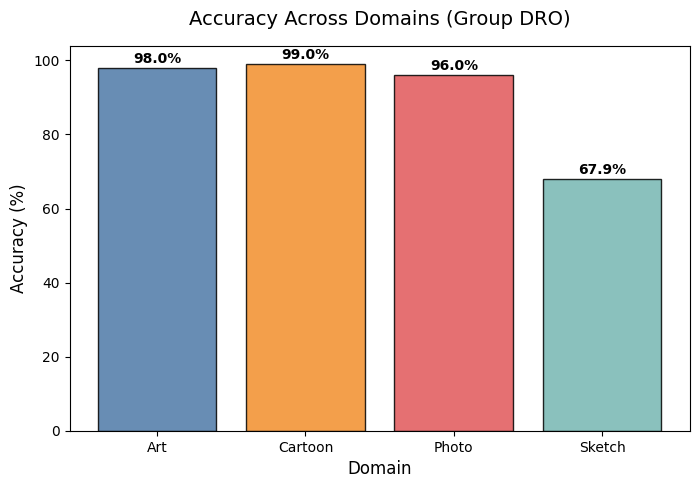

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# === Editable arrays ===
domains = ["Art", "Cartoon", "Photo", "Sketch"]  # labels for the bars
accuracies = [98.0, 99.0, 96.0, 67.93]            # accuracy values
colors = ["#4E79A7", "#F28E2B", "#E15759", "#76B7B2"]  # bar colors

# === Basic bar plot ===
plt.figure(figsize=(8, 5))
bars = plt.bar(domains, accuracies, color=colors, edgecolor="black", alpha=0.85)

# Add value labels above bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f"{acc:.1f}%", ha="center", va="bottom", fontsize=10, fontweight="bold")

# === Customization ===
plt.title("Accuracy Across Domains (Group DRO)", fontsize=14, pad=15)
plt.xlabel("Domain", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
